# Security and Privacy of Machine Learning: Assignment 3
### Andrew Schroeder (s1111686) and Felix Jasper (s1041254)

# Imports

In [1]:
!pip install ipywidgets
!pip3 install pytorch-lightning

In [22]:
from src.Utils import *
from src.DataLoader import *
from src.ResNet18Light import *
from src.ModelUtils import *
from src.TrainingUtils import *
from src.ModelStateDictNames import *
from src.PoisoningUtils import *

# Torch Imports
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.nn.functional import cross_entropy

# Plotting
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
from PIL import Image

# Computation & Math
import math
import numpy as np
import random
import copy

# Utilities
import datetime
from collections import defaultdict
from pprint import pprint
import time
from tqdm import tqdm

# for image loading
from PIL import Image, ImageOps

# Fixing Seed
from pytorch_lightning import seed_everything
seed_everything(42) # reproducibility

Seed set to 42


42

# Settings



Below we specified some settings you will need for this tutorial:
- `TOTAL_CLIENT_NUMBER`: The number of users that participate in the federated learning process. Each will train a model and upload results to a central point where it is aggregated.
- `POISONED_MODEL_RATE`: This percentage specifies how many of the clients/users will be malicious and thus will insert a backdoor in the training data.
- `NUMBER_OF_ADVERSARIES`: The total number of clients/users that is malicious and will insert a backdoor in the training data.
- `NUMBER_OF_BENIGN_CLIENTS`: The total number of clients/users that is benign and will perform clean training.
- `IID_RATE`: The percentage of independent and identically distrubuted data.
- `SAMPLES_PER_CLIENT`: The number of data samples each client will handle.
- `BATCH_SIZE`: The batch size used during training.
- `LOCAL_EPOCHS_FOR_BENIGN_CLIENTS`: The number of epochs for the local training by each client.

In [3]:
# Define configuration classes for each of the main questions to store settings

class Q1_Config:

    # Define parameters
    TOTAL_CLIENT_NUMBER = 5
    NUMBER_OF_ADVERSARIES = 2
    NUMBER_OF_BENIGN_CLIENTS = TOTAL_CLIENT_NUMBER - NUMBER_OF_ADVERSARIES
    IID_RATE = 0.9 # Do we need to do IID? Yes keep to make data distributions more realistic
    POISONING_RATE = 0.5
    GLOBAL_AGGREGATION_ROUNDS = 5
    LOCAL_EPOCHS = 2
    BACKDOOR_TARGET_CLASS = 3  # Cat label
    SELECTED_CLIENTS_PER_ROUND = 5
    AGGREGATION_METHOD = 'FedAvg'

    # Do we need these parameters? Keep until told otherwise.
    SAMPLES_PER_CLIENT = 384
    BATCH_SIZE = 64

In [4]:
#Send computation to a gpu if exists
USE_GPU = True if torch.cuda.is_available() else False
COMPUTATION_DEVICE = torch.device(f"cuda:{0}" if USE_GPU else "cpu")
print(f"Computation Device = {COMPUTATION_DEVICE}")

Computation Device = cpu


/home/andrew/Documents/School/VirtualEnvs/.ML/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Load data and create dataset



We work with the `CIFAR-10` dataset.

We will use two methods from the ```src``` code:

* ```sort_samples_by_labels```: Takes a dataset and sort images based on labels. This to allow sampling from a certain class. This method returns three things:
    - ```training_data_by_labels```: A dict with as key the class labels and as value a list of indices that specify the position of a data sample with that specific label.
    - ```all_labels```: A sorted list of all key values.
    - ```all_training_images```: A numpy array with the indices of all images in the dataset.
* ```create_client_distributions```: Takes total number of clients, the IID rate, samples per client, a list of all labels, a dict of training data indices sorted per label and a list of all image indices (the last three are the output of the ```sort_samples_by_labels``` method). It will output the following things:
    - ```indices_for_clients```: A list that contains as many numpy arrays as the total number of clients. Each numpy array contains all the specific data indices for that specific client.
    - ```main_labels_dict```: A dict that has as key the client number and as value the specific class label that is the main label for that specific client.

For this, we first sort the images by labels to allow sampling only from a certain class. The function ```create_client_distributions``` then randomly selects the main label for each client, chooses the specified fraction of images (1-IID_RATE; IID_RATE was defined above as a constant value) from this main label and sample the remaining images from all available training images.

In [5]:
import urllib.request
urllib.request.urlopen("https://www.google.com")

In [6]:
# Labels in the dataset
CLASSES = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# To achieve a better performance by the ML model, the images are normalized. These values were calculated in advance and put here statically.
# NOTE: should we normalize the images for the blend attack, scaling attack, etc?
STD_DEV = torch.from_numpy(np.array([0.2023, 0.1994, 0.2010]))
MEAN = torch.from_numpy(np.array([0.4914, 0.4822, 0.4465]))

# Transforming and augmenting images
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD_DEV),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD_DEV),
])

# Load the data, store the images and their corresponding labels
DATA_DIRECTORY = './data'
# NOTE: setting download to false to only use local data copy since torchvision URL is down
train_dataset = datasets.CIFAR10(DATA_DIRECTORY, train=True, download=False, transform=transform_train)
test_dataset = [p for p in datasets.CIFAR10(DATA_DIRECTORY, train=False, transform=transform_test)]

In [7]:
def get_client_data_loaders(train_dataset, total_clients, iid_rate, samples_per_client, batch_size):
  """ Gets a list of client data loaders

  For each of `total_clients` dataloaders this function randomly selects the main label for each client, 
  chooses the specified fraction of images (1-IID_RATE) from this main label and sample the remaining images 
  from all available training images.
  
  Args:
    train_dataset (Dataset): the full training dataset with images
    total_clients (int): number of clients for FL (benign+malicious)
    iid_rate (float): percentage of data in the dataloader that comes from the main label. 1-iid_rate samples are random
    samples_per_client (int): the number of image samples each dataloader should have
    batch_size (int): the batch size to use for the dataloaders
  
  """

  # train_data_by_labels: a dictionary of (key, value) pairs where key is a class label and value is a list of indices that have that label
  #   Example: (Airplane, [1, 2, 3, 4, 5, ...])
  # all_lables: a sorted list of all key values
  #   Example: ('Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')
  # all_training_images: a numpy array with the indices of all images in the dataset
  train_data_by_labels, all_labels, all_training_images = sort_samples_by_labels(train_dataset)

  # client_data_indices: a numpy array that contains as many lists as there are clients, with each list containing the indices for the images assigned to that client
  # main_labels_dict: a dictionary of (key, value) pairs where key is the client number, and value is the main label for that client
  #   Example ([Client 1: Airplane, Client 2: Automobile, etc])
  client_data_indices, main_labels_dict = create_client_distributions(total_clients, iid_rate, samples_per_client, all_labels=all_labels, train_data_by_labels=train_data_by_labels,all_training_images=all_training_images)

  # Since all training samples of a client (384 samples/client) might not fit into the GPU memory, we divide them into multiple batches and train them sequentially.
  # Each batch is 64 images large. 384/64 = 6 batches to get through all samples

  # client_data_laoders store a data loader for each client
  # each of these dataloaders will then serve up the clients respective data in 64 image chunks (for batching)
  client_data_loaders = []
  for indices in tqdm(client_data_indices):
    data_loader = MyDataLoader(train_dataset, indices, batch_size)
    client_data_loaders.append(data_loader)

  return client_data_loaders

# Global Model Initialization

## Instantiation of global model (server-side)

Load the global `ResNet18Light` model

In [8]:
# instantiate the model
global_model = ResNet18Light('GlobalModel')

## Load Pretrained Model

In [9]:
# Prepare some data for testing
test_data = batchify(test_dataset, 1024, len(test_dataset))

In [10]:
# Download the pretrained model
!pip install wget
!python -m wget -o R0099.pt https://docs.trust-sysec.com/FF9FB2E7-7460-48D9-BFF8-529D6C528CD6/R0099.pt

100% [....................................................] 11231292 / 11231292
Saved under R0099 (2).pt


In [11]:
# Load the pretrained model
global_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
global_model.load_state_dict(global_model_state_dict)

# Move the global model to the gpu and test its initial performance
global_model.to(COMPUTATION_DEVICE)
test_data = [(x.to(COMPUTATION_DEVICE), y.to(COMPUTATION_DEVICE)) for x, y in test_data]
print(f'Accuracy: {test(test_data, global_model)}%')

2025-06-06 12:13:01.326588: ___Test GlobalModel_ResNet_18: Average loss: 0.8361, Accuracy: 7486/10000 (74.8600%)
Accuracy: 74.86%


## Model Aggregation Methods

In [29]:
def flatten_model(state_dict, param_names):

    flattened_params = []
    for name in param_names:
        
        # flatten reshapes input into a one-dimensional tensor
        flattened_params.append(state_dict[name].flatten().cpu())

    # Combine all flattened 1D params together using cat
    combined_flattened_params = torch.cat(flattened_params).numpy()
    
    return combined_flattened_params


def aggregate_weights_krum(all_models, base_model, num_malicious=2, verbose=True):
    # Note rewrite in your own words
    """
    Perform Krum algorithm

    Args:
        all_models : list of state dicts, containing the locally trained parameters of the individual clients
        base_model : state dict of arbitrary model, useful for knowing the names of all parameters and copying values of not
                     aggregated parameters

    Returns:
        return state dict of aggregated model (obtained by krum)
    """

    if verbose:
        print_timed(f'Krum aggregate {len(all_models)} models')

    param_names = NAMES_OF_AGGREGATED_PARAMETERS

    # First we need to flatten the the model weights
    flat_model_weights = [flatten_model(model, param_names) for model in all_models]
    n_models = len(all_models)

    client_scores = []
    for i in range(n_models):
        distances = []
        for j in range(n_models):
            if i != j:
                distances.append(np.linalg.norm(flat_model_weights[i] - flat_model_weights[j])**2)

        # We need to sort the distances and select the closest n-f-2 
        closest = sorted(distances)[:n_models-num_malicious-2]
        
        # Then sum the n-f-2 distances
        score = sum(closest)

        # Add to list of client scores
        client_scores.append(score)

    # Now we take the client with the lowest score
    selected_model_index = np.argmin(client_scores)
    # And grab its dictionary to return
    selected_model_dict = all_models[selected_model_index]

    return selected_model_dict


# The Following function was taking from Tutorial 8 on Federated Learning
def aggregate_weights_fedavg(all_models, base_model, verbose=True):
    """
    Perform FedAvg algorithm
    :param all_models list of state dicts, containing the locally trained parameters of the individual clients
    :param base_model state dict of arbitrary model, useful for knowing the names of all parameters and copying values of not
    aggregated parameters
    :return state dict of aggregated model (obtained by FedAvg)
    """

    if verbose:
        print_timed(f'FedAvg aggregate {len(all_models)} models')

    result_state_dict = {name: torch.zeros_like(data) for name, data in base_model.items()}
    n_models = len(all_models)


    for model in all_models:
        for name in model:
            if name in NAMES_OF_AGGREGATED_PARAMETERS:
                if USE_GPU:
                    result_state_dict[name] += torch.Tensor(model[name]/n_models).cuda()
                else:
                    result_state_dict[name] += torch.Tensor(model[name]/n_models).cpu()
            else:
                result_state_dict[name] = model[name]

    return result_state_dict


# Local Model Initialization

In [13]:
local_model = ResNet18Light('LocalModel').to(COMPUTATION_DEVICE)

# 1. Backdoor Attack in Federated Learning (5 points)

## (a) (2 points) Source Agnostic FL with Blend Attack

Make the client dataloaders


In [14]:
# Create dataloaders
all_data_loaders = get_client_data_loaders(train_dataset, Q1_Config.TOTAL_CLIENT_NUMBER, Q1_Config.IID_RATE, Q1_Config.SAMPLES_PER_CLIENT, Q1_Config.BATCH_SIZE)

# Split dataloaders up into good and bad
benign_data_loaders = all_data_loaders[:Q1_Config.NUMBER_OF_BENIGN_CLIENTS]
poisoned_data_loaders = all_data_loaders[Q1_Config.NUMBER_OF_BENIGN_CLIENTS:]

50000it [00:10, 4944.55it/s]


2025-06-06 12:13:11.505188: Samples from main class per client: 38
2025-06-06 12:13:11.505230: Samples from all classes per client: 346
2025-06-06 12:13:11.508813: Main label for clients: {0: 6, 1: 3, 2: 7, 3: 4, 4: 6} 


100%|██████████| 5/5 [00:00<00:00, 12.54it/s]


Poison the data in the bad data loader

In [15]:

import importlib
import src.PoisoningUtils
importlib.reload(src.PoisoningUtils)
from src.PoisoningUtils import *
poisoned_data_loaders = [BlendTriggerBackdoorData(dataset, Q1_Config.POISONING_RATE, COMPUTATION_DEVICE, Q1_Config.BACKDOOR_TARGET_CLASS) for dataset in poisoned_data_loaders]

Visualise some bad data

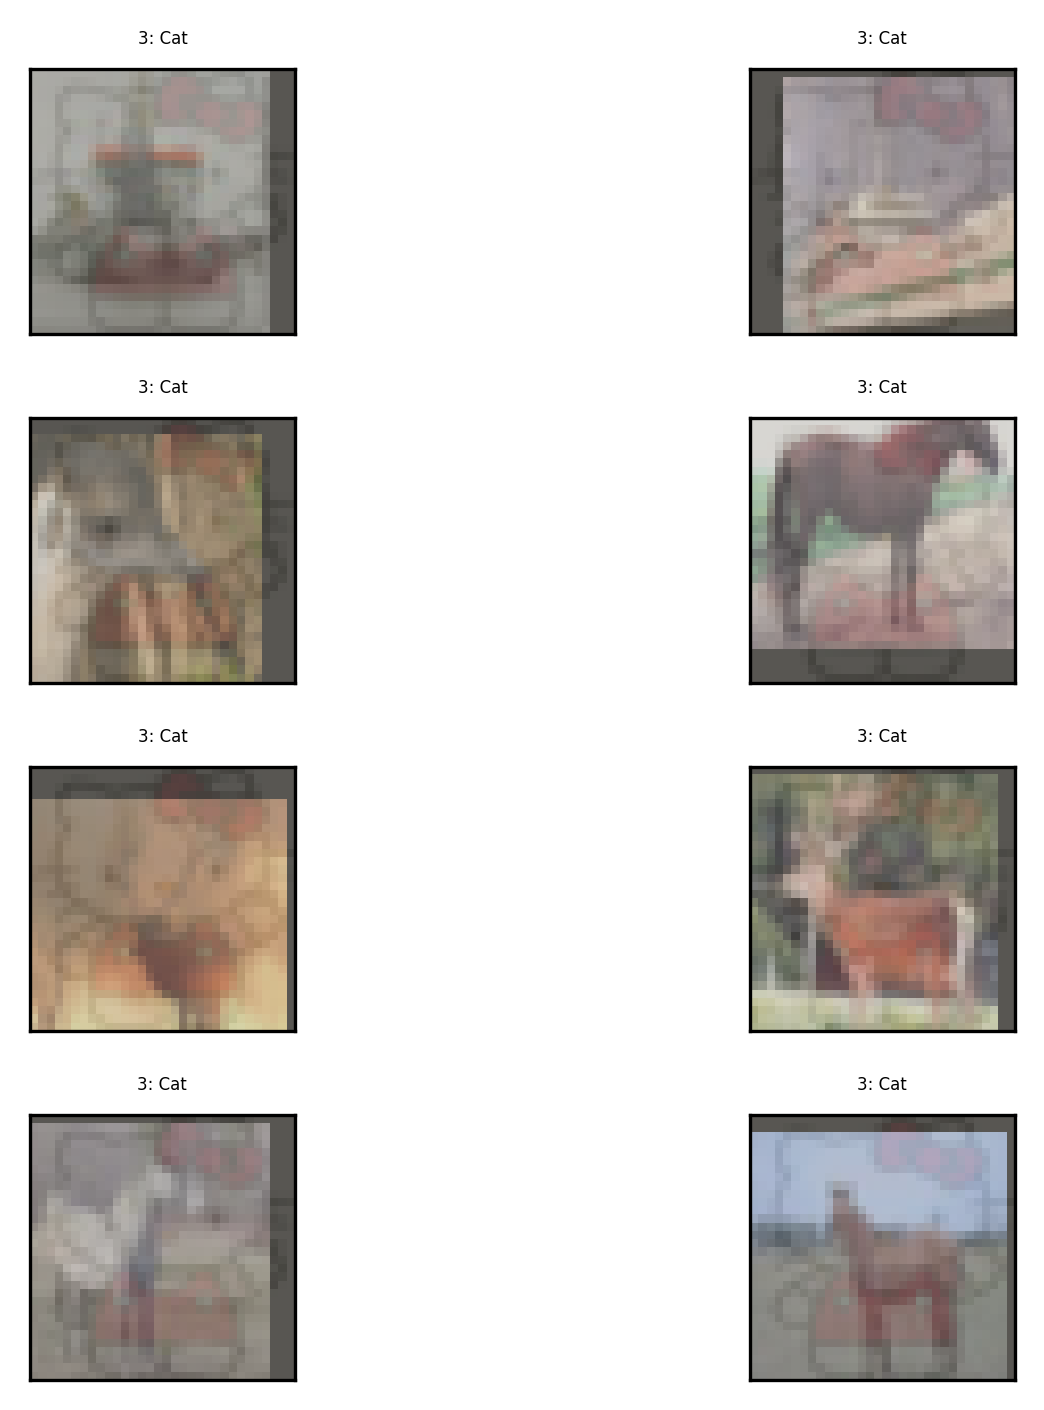

In [16]:
poisoned_dataset = poisoned_data_loaders[0]

fig, axs = plt.subplots(4, 2,dpi=300)

for i in range(0, 8):
    x = int(i//4)
    y = i % 4
    axs[y,x].set_title(f'{poisoned_dataset.batches[0][1][i]}: {CLASSES[poisoned_dataset.batches[0][1][i]]}', fontsize=4)
    axs[y,x].imshow(unnormalize_image(poisoned_dataset.batches[1][0][i], STD_DEV=STD_DEV, MEAN=MEAN))
    axs[y,x].get_xaxis().set_visible(False)
    axs[y,x].get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

Create test data for evaluating how well the backdoor is trained (and later, how well the backdoor is injected into the aggregated model). 

In [17]:
# all_test_samples will stores all our test samples EXCEPT those that match the BACKDOOR_TARGET_CLASS (3: Cat)
all_test_samples = []
for image, label in test_dataset:
    if label == Q1_Config.BACKDOOR_TARGET_CLASS:
        continue
    all_test_samples.append((image, label))

# Create a new test data_loader with batch_size=1024
backdoor_test_data_loader = torch.utils.data.DataLoader(all_test_samples, batch_size=1024, shuffle=True)

# ColorTriggerBackdoorData is neither a Dataset or Dataloader
# It is a wrapper that takes existing data_loader (already batched data), iterates through the batches, poisons a fraction of each batch's images

# NOTE: Why are we using 100% poisoning rate here?
backdoor_test_data = BlendTriggerBackdoorData(backdoor_test_data_loader, 1.0, COMPUTATION_DEVICE, Q1_Config.BACKDOOR_TARGET_CLASS)

# Move the data to device
if USE_GPU:
    backdoor_test_data.cuda()
else:   
    backdoor_test_data.cpu()


Visualise some of the test data set

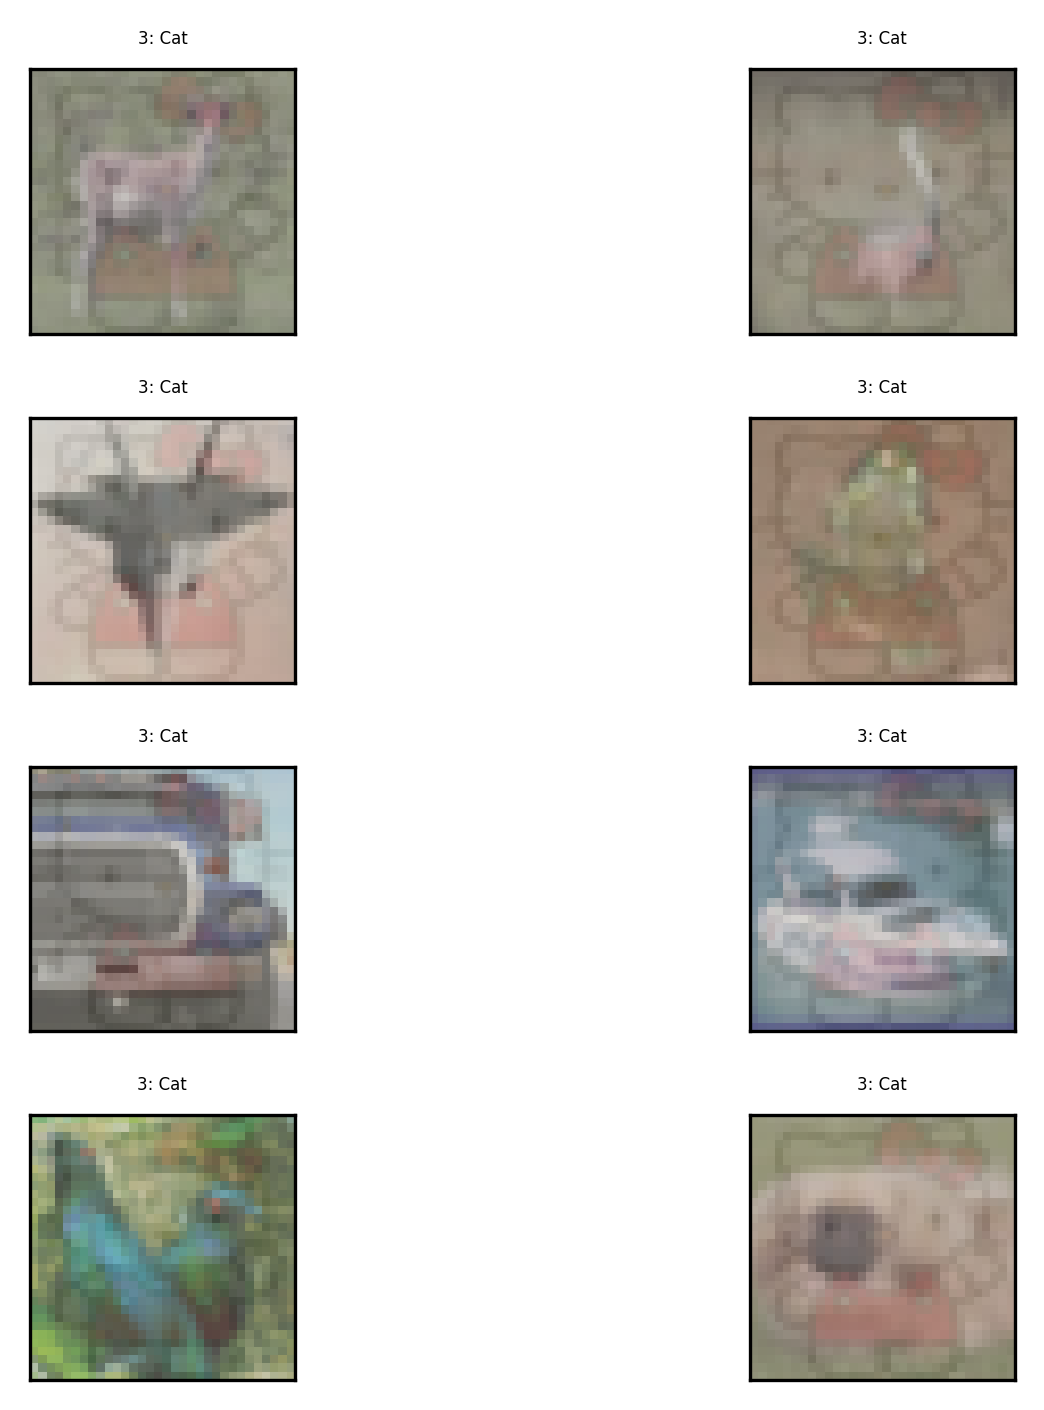

In [18]:
fig, axs = plt.subplots(4, 2,dpi=300)

for i in range(0, 8):
    x = int(i//4)
    y = i % 4
    axs[y,x].set_title(f'{backdoor_test_data.batches[0][1][i]}: {CLASSES[backdoor_test_data.batches[0][1][i]]}', fontsize=4)
    axs[y,x].imshow(unnormalize_image(backdoor_test_data.batches[1][0][i], STD_DEV=STD_DEV, MEAN=MEAN))
    axs[y,x].get_xaxis().set_visible(False)
    axs[y,x].get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

### Distributed Training FedAvg Aggregation


#### Do a real Federated Learning run

Define two functions
1. `FL_aggregration_round` which does one round of FL training on the clients
2. `full_training` which calls `FL_aggregation_round` multiple times and returns MA and BA statistics for each round

In [ ]:
def FL_aggregation_round(model, aggregation_function, benign_data_loaders, poisoned_data_loaders, epochs):
    '''
    # Conducts one round of federated learning and returns the new aggregated model
    # model is the global model
    # 
    '''
    model_state_dict = model.state_dict()

    # Benign weights
    all_trained_benign_weights = []
    for client_index in range(len(benign_data_loaders)):
        print_timed(f'Client {client_index}')
        trained_weights = client_training(model_state_dict, local_model, benign_data_loaders[client_index], printing_prefix='\t', local_epochs=epochs, COMPUTATION_DEVICE=COMPUTATION_DEVICE)
        all_trained_benign_weights.append(copy.deepcopy(trained_weights))


    # Poisoned weights
    all_trained_poisoned_weights = []
    for client_index in range(len(poisoned_data_loaders)):
        print_timed(f'Client {client_index}')
        trained_poisoned_weights = client_training(model_state_dict, local_model, poisoned_data_loaders[client_index], local_epochs=epochs, COMPUTATION_DEVICE=COMPUTATION_DEVICE)
        all_trained_poisoned_weights.append(copy.deepcopy(trained_poisoned_weights))

    # Aggregate the benign and poisoned weights together
    all_model_weights = all_trained_benign_weights + all_trained_poisoned_weights

    # Hash model weights before aggregating (comment out to speed up training)
    # hash_values = get_models_hash(all_model_weights)
    # Run aggregation
    aggregated_weights = aggregation_function(all_model_weights, model_state_dict)
    # Make sure local models have not been changed (comment out to speed up training)
    # check_hashs(all_model_weights, hash_values)

    model.load_state_dict(aggregated_weights)

    return model

In [20]:
# Make a copy of the global model so that we don't modify the global model by accident
def full_training(global_model, benign_data_loaders, poisoned_data_loaders, aggregation_function=aggregate_weights_fedavg):
    aggregated_model = global_model

    print(f"Distributed training started with {aggregation_function.__name__}")

    # Do 5 rounds of aggregation...
    aggregation_round_stats = []
    for i in tqdm(range(Q1_Config.GLOBAL_AGGREGATION_ROUNDS)):
        print(f"Aggregation round: {i+1}/{Q1_Config.GLOBAL_AGGREGATION_ROUNDS}...")
        new_aggregated_model = FL_aggregation_round(aggregated_model, aggregation_function, benign_data_loaders, poisoned_data_loaders, Q1_Config.LOCAL_EPOCHS)
        # Set the new global_model to be the newly aggregated model
        aggregated_model = new_aggregated_model
    
        # Evaluate model on each round and save performance statistics
        (MA, BA) = evaluate_model(aggregated_model, name='Aggregated Model', test_data=test_data, backdoor_test_data=backdoor_test_data)
        aggregation_round_stats.append((MA, BA))
    return aggregation_round_stats

In [23]:
# instantiate the model from scratch to avoid any artifacts from training code above
global_model = ResNet18Light('GlobalModel')
global_model.to(COMPUTATION_DEVICE)

# Load pretraiend model
global_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
global_model.load_state_dict(global_model_state_dict)

# Do training with Fedavg
aggregation_round_stats = full_training(global_model, benign_data_loaders, poisoned_data_loaders, aggregate_weights_fedavg)
print(aggregation_round_stats)

Distributed training started with aggregate_weights_fedavg


  0%|          | 0/5 [00:00<?, ?it/s]

Aggregation round: 1/5...
2025-06-06 12:13:55.224125: Client 0
2025-06-06 12:13:56.396046: 	local_epoch   0 | lr 0.2 | ms/batch 1168.98| loss  3.82
2025-06-06 12:13:57.623335: 	local_epoch   1 | lr 0.2 | ms/batch 1227.16| loss  0.94
2025-06-06 12:13:57.630692: Client 1
2025-06-06 12:13:58.890635: 	local_epoch   0 | lr 0.2 | ms/batch 1256.51| loss  4.00
2025-06-06 12:14:00.132528: 	local_epoch   1 | lr 0.2 | ms/batch 1241.77| loss  1.05
2025-06-06 12:14:00.139400: Client 2
2025-06-06 12:14:01.412782: 	local_epoch   0 | lr 0.2 | ms/batch 1270.47| loss  3.17
2025-06-06 12:14:02.696496: 	local_epoch   1 | lr 0.2 | ms/batch 1283.61| loss  0.84
2025-06-06 12:14:02.702043: Client 0
2025-06-06 12:14:03.948976: local_epoch   0 | lr 0.2 | ms/batch 1243.42| loss  8.76
2025-06-06 12:14:05.201973: local_epoch   1 | lr 0.2 | ms/batch 1252.87| loss  3.08
2025-06-06 12:14:05.209291: Client 1
2025-06-06 12:14:06.459067: local_epoch   0 | lr 0.2 | ms/batch 1246.88| loss  9.11
2025-06-06 12:14:07.681204:

 20%|██        | 1/5 [00:42<02:49, 42.27s/it]

2025-06-06 12:14:37.489076: Performance of Aggregated Model: MA=55.98 BA=99.20
Aggregation round: 2/5...
2025-06-06 12:14:37.490794: Client 0
2025-06-06 12:14:38.742160: 	local_epoch   0 | lr 0.2 | ms/batch 1247.47| loss  2.73
2025-06-06 12:14:39.974035: 	local_epoch   1 | lr 0.2 | ms/batch 1231.76| loss  0.70
2025-06-06 12:14:39.979514: Client 1
2025-06-06 12:14:41.227813: 	local_epoch   0 | lr 0.2 | ms/batch 1245.07| loss  1.86
2025-06-06 12:14:42.464153: 	local_epoch   1 | lr 0.2 | ms/batch 1236.24| loss  0.56
2025-06-06 12:14:42.469770: Client 2
2025-06-06 12:14:43.757499: 	local_epoch   0 | lr 0.2 | ms/batch 1284.11| loss  2.28
2025-06-06 12:14:44.997668: 	local_epoch   1 | lr 0.2 | ms/batch 1240.06| loss  0.76
2025-06-06 12:14:45.004490: Client 0
2025-06-06 12:14:46.237530: local_epoch   0 | lr 0.2 | ms/batch 1229.72| loss  0.96
2025-06-06 12:14:47.479342: local_epoch   1 | lr 0.2 | ms/batch 1241.69| loss  0.13
2025-06-06 12:14:47.485278: Client 1
2025-06-06 12:14:48.722322: loca

 40%|████      | 2/5 [01:25<02:07, 42.66s/it]

2025-06-06 12:15:20.430664: Performance of Aggregated Model: MA=77.57 BA=81.76
Aggregation round: 3/5...
2025-06-06 12:15:20.432552: Client 0
2025-06-06 12:15:21.787218: 	local_epoch   0 | lr 0.2 | ms/batch 1351.01| loss  0.51
2025-06-06 12:15:23.050991: 	local_epoch   1 | lr 0.2 | ms/batch 1263.67| loss  0.08
2025-06-06 12:15:23.056303: Client 1
2025-06-06 12:15:24.295879: 	local_epoch   0 | lr 0.2 | ms/batch 1236.59| loss  0.34
2025-06-06 12:15:25.522036: 	local_epoch   1 | lr 0.2 | ms/batch 1226.02| loss  0.06
2025-06-06 12:15:25.527314: Client 2
2025-06-06 12:15:26.727618: 	local_epoch   0 | lr 0.2 | ms/batch 1197.39| loss  0.40
2025-06-06 12:15:27.960834: 	local_epoch   1 | lr 0.2 | ms/batch 1233.10| loss  0.07
2025-06-06 12:15:27.967890: Client 0
2025-06-06 12:15:29.170624: local_epoch   0 | lr 0.2 | ms/batch 1199.27| loss  0.87
2025-06-06 12:15:30.399870: local_epoch   1 | lr 0.2 | ms/batch 1229.13| loss  0.09
2025-06-06 12:15:30.406620: Client 1
2025-06-06 12:15:31.699606: loca

 60%|██████    | 3/5 [02:08<01:25, 42.78s/it]

2025-06-06 12:16:03.348558: Performance of Aggregated Model: MA=76.27 BA=98.42
Aggregation round: 4/5...
2025-06-06 12:16:03.350436: Client 0
2025-06-06 12:16:04.571861: 	local_epoch   0 | lr 0.2 | ms/batch 1217.00| loss  0.35
2025-06-06 12:16:05.774108: 	local_epoch   1 | lr 0.2 | ms/batch 1202.12| loss  0.13
2025-06-06 12:16:05.779639: Client 1
2025-06-06 12:16:07.056401: 	local_epoch   0 | lr 0.2 | ms/batch 1274.00| loss  0.15
2025-06-06 12:16:08.377689: 	local_epoch   1 | lr 0.2 | ms/batch 1321.14| loss  0.04
2025-06-06 12:16:08.384158: Client 2
2025-06-06 12:16:09.703587: 	local_epoch   0 | lr 0.2 | ms/batch 1316.07| loss  0.29
2025-06-06 12:16:10.908574: 	local_epoch   1 | lr 0.2 | ms/batch 1204.88| loss  0.08
2025-06-06 12:16:10.914762: Client 0
2025-06-06 12:16:12.177282: local_epoch   0 | lr 0.2 | ms/batch 1259.29| loss  0.12
2025-06-06 12:16:13.405286: local_epoch   1 | lr 0.2 | ms/batch 1227.89| loss  0.03
2025-06-06 12:16:13.410955: Client 1
2025-06-06 12:16:14.640934: loca

 80%|████████  | 4/5 [02:50<00:42, 42.79s/it]

2025-06-06 12:16:46.162759: Performance of Aggregated Model: MA=79.13 BA=94.26
Aggregation round: 5/5...
2025-06-06 12:16:46.164740: Client 0
2025-06-06 12:16:47.392698: 	local_epoch   0 | lr 0.2 | ms/batch 1223.83| loss  0.09
2025-06-06 12:16:48.567436: 	local_epoch   1 | lr 0.2 | ms/batch 1174.63| loss  0.03
2025-06-06 12:16:48.572637: Client 1
2025-06-06 12:16:49.940235: 	local_epoch   0 | lr 0.2 | ms/batch 1364.63| loss  0.06
2025-06-06 12:16:51.205087: 	local_epoch   1 | lr 0.2 | ms/batch 1264.73| loss  0.03
2025-06-06 12:16:51.210362: Client 2
2025-06-06 12:16:52.453390: 	local_epoch   0 | lr 0.2 | ms/batch 1240.19| loss  0.08
2025-06-06 12:16:53.696732: 	local_epoch   1 | lr 0.2 | ms/batch 1243.23| loss  0.03
2025-06-06 12:16:53.702049: Client 0
2025-06-06 12:16:54.862029: local_epoch   0 | lr 0.2 | ms/batch 1157.13| loss  0.15
2025-06-06 12:16:56.002406: local_epoch   1 | lr 0.2 | ms/batch 1140.26| loss  0.03
2025-06-06 12:16:56.007502: Client 1
2025-06-06 12:16:57.178552: loca

100%|██████████| 5/5 [03:33<00:00, 42.70s/it]

2025-06-06 12:17:28.718140: Performance of Aggregated Model: MA=78.48 BA=97.88
[(55.98, 99.2), (77.57, 81.75555555555556), (76.27000000000001, 98.42222222222222), (79.13, 94.25555555555556), (78.48, 97.87777777777778)]


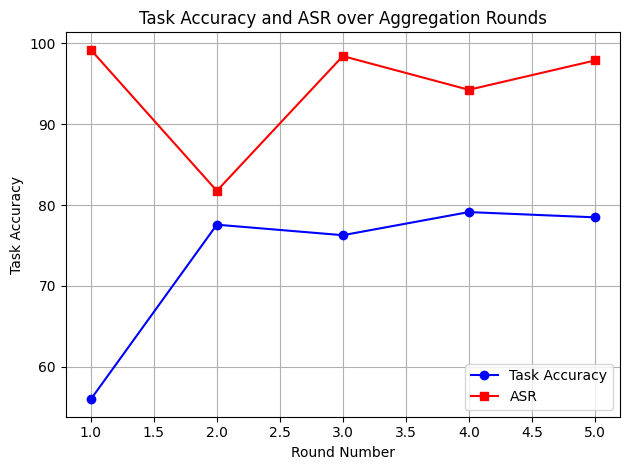

In [24]:
import matplotlib.pyplot as plt

def plot_results(aggregation_round_stats):
    results = aggregation_round_stats

    rounds = list(range(1, len(results) + 1))
    accuracy_values = [x[0] for x in results]
    asr_values = [x[1] for x in results]

    fig, ax1 = plt.subplots()

    ax1.plot(rounds, accuracy_values, 'b-o', label='Task Accuracy')
    ax1.plot(rounds, asr_values, 'r-s', label='ASR')
    ax1.set_xlabel('Round Number')
    ax1.set_ylabel('Task Accuracy')

    plt.title('Task Accuracy and ASR over Aggregation Rounds')
    fig.tight_layout()
    plt.legend()
    plt.grid(True)
    plt.show()

plot_results(aggregation_round_stats)

## (b) (2 points) Source Agnostic FL with Krum Attack

In [30]:
import copy
# instantiate the model from scratch to avoid any artifacts from training code above
global_model = ResNet18Light('GlobalModel')
global_model.to(COMPUTATION_DEVICE)

# Load pretraiend model
global_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
global_model.load_state_dict(global_model_state_dict)

# Do training with Fedavg
training_stats_krum = full_training(global_model, benign_data_loaders, poisoned_data_loaders, aggregate_weights_krum)
print(training_stats_krum)

Distributed training started with aggregate_weights_krum


  0%|          | 0/5 [00:00<?, ?it/s]

Aggregation round: 1/5...
2025-06-06 12:20:46.107809: Client 0
2025-06-06 12:20:47.325224: 	local_epoch   0 | lr 0.2 | ms/batch 1214.34| loss  3.82
2025-06-06 12:20:48.589777: 	local_epoch   1 | lr 0.2 | ms/batch 1264.45| loss  0.94
2025-06-06 12:20:48.595283: Client 1
2025-06-06 12:20:49.863722: 	local_epoch   0 | lr 0.2 | ms/batch 1265.65| loss  4.00
2025-06-06 12:20:51.093393: 	local_epoch   1 | lr 0.2 | ms/batch 1229.56| loss  1.05
2025-06-06 12:20:51.099211: Client 2
2025-06-06 12:20:52.311145: 	local_epoch   0 | lr 0.2 | ms/batch 1208.75| loss  3.17
2025-06-06 12:20:53.568541: 	local_epoch   1 | lr 0.2 | ms/batch 1257.29| loss  0.84
2025-06-06 12:20:53.574352: Client 0
2025-06-06 12:20:54.818319: local_epoch   0 | lr 0.2 | ms/batch 1240.96| loss  8.76
2025-06-06 12:20:56.051190: local_epoch   1 | lr 0.2 | ms/batch 1232.76| loss  3.08
2025-06-06 12:20:56.057324: Client 1
2025-06-06 12:20:57.296977: local_epoch   0 | lr 0.2 | ms/batch 1236.13| loss  9.11
2025-06-06 12:20:58.542552:

 20%|██        | 1/5 [00:43<02:52, 43.05s/it]

2025-06-06 12:21:29.158315: Performance of Aggregated Model: MA=57.22 BA=4.53
Aggregation round: 2/5...
2025-06-06 12:21:29.160092: Client 0
2025-06-06 12:21:30.399872: 	local_epoch   0 | lr 0.2 | ms/batch 1236.26| loss  0.39
2025-06-06 12:21:31.602462: 	local_epoch   1 | lr 0.2 | ms/batch 1202.47| loss  0.11
2025-06-06 12:21:31.608452: Client 1
2025-06-06 12:21:32.839001: 	local_epoch   0 | lr 0.2 | ms/batch 1227.77| loss  6.34
2025-06-06 12:21:34.111082: 	local_epoch   1 | lr 0.2 | ms/batch 1271.96| loss  2.01
2025-06-06 12:21:34.116550: Client 2
2025-06-06 12:21:35.510757: 	local_epoch   0 | lr 0.2 | ms/batch 1391.36| loss  5.44
2025-06-06 12:21:36.736739: 	local_epoch   1 | lr 0.2 | ms/batch 1225.79| loss  2.00
2025-06-06 12:21:36.743146: Client 0
2025-06-06 12:21:38.190516: local_epoch   0 | lr 0.2 | ms/batch 1444.35| loss  9.08
2025-06-06 12:21:39.660728: local_epoch   1 | lr 0.2 | ms/batch 1470.11| loss  3.86
2025-06-06 12:21:39.666195: Client 1
2025-06-06 12:21:41.120403: local

 40%|████      | 2/5 [01:28<02:13, 44.59s/it]

2025-06-06 12:22:14.822047: Performance of Aggregated Model: MA=70.65 BA=8.93
Aggregation round: 3/5...
2025-06-06 12:22:14.823756: Client 0
2025-06-06 12:22:16.079875: 	local_epoch   0 | lr 0.2 | ms/batch 1252.65| loss  0.04
2025-06-06 12:22:17.314039: 	local_epoch   1 | lr 0.2 | ms/batch 1234.03| loss  0.03
2025-06-06 12:22:17.320198: Client 1
2025-06-06 12:22:18.468150: 	local_epoch   0 | lr 0.2 | ms/batch 1144.31| loss  5.89
2025-06-06 12:22:19.661400: 	local_epoch   1 | lr 0.2 | ms/batch 1193.15| loss  1.98
2025-06-06 12:22:19.666516: Client 2
2025-06-06 12:22:20.799343: 	local_epoch   0 | lr 0.2 | ms/batch 1130.04| loss  5.44
2025-06-06 12:22:22.019569: 	local_epoch   1 | lr 0.2 | ms/batch 1220.11| loss  1.85
2025-06-06 12:22:22.026065: Client 0
2025-06-06 12:22:23.250732: local_epoch   0 | lr 0.2 | ms/batch 1221.30| loss  9.06
2025-06-06 12:22:24.506439: local_epoch   1 | lr 0.2 | ms/batch 1255.58| loss  3.58
2025-06-06 12:22:24.511751: Client 1
2025-06-06 12:22:25.686031: local

 60%|██████    | 3/5 [02:10<01:27, 43.53s/it]

2025-06-06 12:22:57.094610: Performance of Aggregated Model: MA=71.59 BA=6.98
Aggregation round: 4/5...
2025-06-06 12:22:57.096230: Client 0
2025-06-06 12:22:58.340898: 	local_epoch   0 | lr 0.2 | ms/batch 1241.47| loss  0.02
2025-06-06 12:22:59.562361: 	local_epoch   1 | lr 0.2 | ms/batch 1221.32| loss  0.02
2025-06-06 12:22:59.568378: Client 1
2025-06-06 12:23:00.756459: 	local_epoch   0 | lr 0.2 | ms/batch 1185.15| loss  5.92
2025-06-06 12:23:01.941894: 	local_epoch   1 | lr 0.2 | ms/batch 1185.33| loss  2.01
2025-06-06 12:23:01.947619: Client 2
2025-06-06 12:23:03.216908: 	local_epoch   0 | lr 0.2 | ms/batch 1266.52| loss  5.42
2025-06-06 12:23:04.487656: 	local_epoch   1 | lr 0.2 | ms/batch 1270.62| loss  1.93
2025-06-06 12:23:04.493197: Client 0
2025-06-06 12:23:05.656669: local_epoch   0 | lr 0.2 | ms/batch 1160.61| loss  9.12
2025-06-06 12:23:06.868408: local_epoch   1 | lr 0.2 | ms/batch 1211.63| loss  3.65
2025-06-06 12:23:06.873500: Client 1
2025-06-06 12:23:08.057397: local

 80%|████████  | 4/5 [02:53<00:43, 43.14s/it]

2025-06-06 12:23:39.637977: Performance of Aggregated Model: MA=71.67 BA=6.82
Aggregation round: 5/5...
2025-06-06 12:23:39.639936: Client 0
2025-06-06 12:23:40.846881: 	local_epoch   0 | lr 0.2 | ms/batch 1202.96| loss  0.02
2025-06-06 12:23:42.011587: 	local_epoch   1 | lr 0.2 | ms/batch 1164.59| loss  0.02
2025-06-06 12:23:42.017523: Client 1
2025-06-06 12:23:43.204880: 	local_epoch   0 | lr 0.2 | ms/batch 1184.60| loss  5.97
2025-06-06 12:23:44.420583: 	local_epoch   1 | lr 0.2 | ms/batch 1215.58| loss  2.12
2025-06-06 12:23:44.426044: Client 2
2025-06-06 12:23:45.636263: 	local_epoch   0 | lr 0.2 | ms/batch 1207.38| loss  5.40
2025-06-06 12:23:46.843299: 	local_epoch   1 | lr 0.2 | ms/batch 1206.93| loss  1.98
2025-06-06 12:23:46.849203: Client 0
2025-06-06 12:23:48.023834: local_epoch   0 | lr 0.2 | ms/batch 1171.77| loss  9.15
2025-06-06 12:23:49.244122: local_epoch   1 | lr 0.2 | ms/batch 1220.17| loss  3.50
2025-06-06 12:23:49.249575: Client 1
2025-06-06 12:23:50.490289: local

100%|██████████| 5/5 [03:35<00:00, 43.19s/it]

2025-06-06 12:24:22.048122: Performance of Aggregated Model: MA=71.81 BA=6.72
[(57.220000000000006, 4.533333333333333), (70.65, 8.933333333333334), (71.59, 6.977777777777777), (71.67, 6.822222222222223), (71.81, 6.722222222222222)]


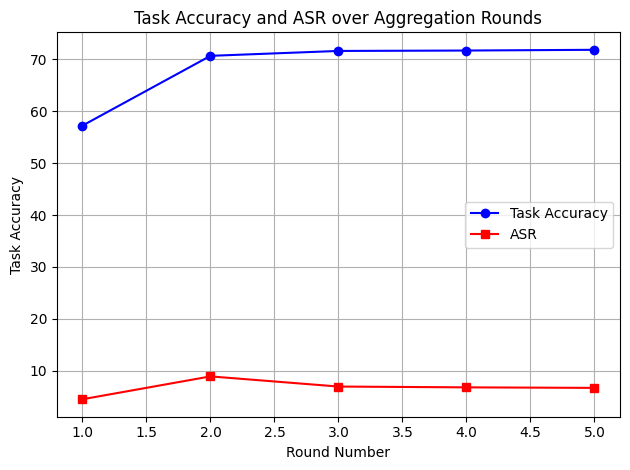

In [31]:
plot_results(training_stats_krum)

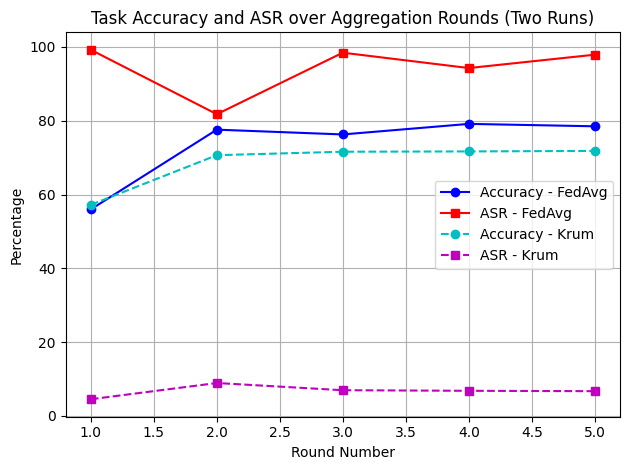

In [32]:
import matplotlib.pyplot as plt


def plot_two_results(aggregation_round_stats_1, aggregation_round_stats_2):
    
    rounds_1 = list(range(1, len(aggregation_round_stats_1) + 1))
    accuracy_1 = [x[0] for x in aggregation_round_stats_1]
    asr_1 = [x[1] for x in aggregation_round_stats_1]

    rounds_2 = list(range(1, len(aggregation_round_stats_2) + 1))
    accuracy_2 = [x[0] for x in aggregation_round_stats_2]
    asr_2 = [x[1] for x in aggregation_round_stats_2]

    fig, ax1 = plt.subplots()

    ax1.plot(rounds_1, accuracy_1, 'b-o', label='Accuracy - FedAvg')
    ax1.plot(rounds_1, asr_1, 'r-s', label='ASR - FedAvg')
    ax1.plot(rounds_2, accuracy_2, 'c--o', label='Accuracy - Krum')
    ax1.plot(rounds_2, asr_2, 'm--s', label='ASR - Krum')

    # Labels and title
    ax1.set_xlabel('Round Number')
    ax1.set_ylabel('Percentage')
    plt.title('Task Accuracy and ASR over Aggregation Rounds (Two Runs)')
    plt.legend()
    plt.grid(True)
    fig.tight_layout()
    plt.show()

plot_two_results(aggregation_round_stats, training_stats_krum)

## (c) (1 point) Comparing Krum and FedAvg

### FedAvg Aggregator
FedAvg is simply an average of the model weights and is defined as:

$$w_{t+1}^{avg} \leftarrow \sum_{k=1}^{K}\frac{w_t^k}{K}$$

Where:
- $w_t$: is the aggregated weight of the model at time $t$
- $K$: is the total number of clients
- $w_t^k$ are the weigts for client model $k$ at time $t$

It usually assumses honest clients and that data is coming from trustworthy sources and thus is sensitive to malicious updates.

### Krum Aggregator
The Krum aggregator is a Byzantine-resilient aggregation method used to defend against poisonous updates. The mathematical formulation is the following. We have the following terms

- $n$: total number of clients
- $f$: number of byzantine or malicious clients
- $w$: model weights

Then the Krum aggrector computes a score for each $w_i$ by doing the following:
1. Computes the square euclidean distance between each $w_i$ and every other $w_j$
2. It then sums the the $n-f-2$ closest distances to other weights
3. Then of all the $n$ scores, it returns the $w_i$ with the minimum score.

We can describe in math as the follows:

$$\text{score}(w_i)=\sum_j||w_i-w_j||^2 \text{ where } j\in\text{Closest}(w_i, n-f-2)$$
$$\text{Return } \min (\text{score}(w_i), i\in n)$$

This model can defend up to $f$ byzantine models, but it is noisy because it doesn't always pick the best model, but it avoids poisoned ones. 

### Comparison on MA and BA Metrics
As seen in the graph above, both Krum and FedAvg both perform reasonably well on the MA scores, converging to approximately 75%, with FedAvg outperforming Krum slightly. However, the FedAvg has a much higher ASR, mostly in the 90% range meaning the blend attack was very effective. In comparison the Krum model has a very low ASR, mostly less than 10% which is what we expect because Krum with $f=2$ should be resilient to two malicious clients, which is what we have.


# 2. Distributed Backdoor Attack (3 points) - Felix

# 3. Scaling Attack (2 points) - Felix
So far the backdoor attack was not really effective. A reason for this is, that the poisoned model is aggregated along with the other 20 benign models and the backdoor will therefore be cancelled out during the aggregation process. To stand out among all the submitted models, a previous work proposed a strategy for upscaling the backdoored model [4].
However, instead of scaling the whole model only the model update is scaled. For a local model $W$ trained based on a previous global model $G_{t-1}$, the model update $U$ is defined as:
$$U=W-G_{t-1}$$
Assuming that for later FL rounds, where the model is already close to convergence (the benign models do not change significantly), the aggregated model can be replaced with the model $W_{A}$, by submitting a scaled model $W_A^*$:
$$W_A^*= \gamma (W_A - G_{t-1}) + G_{t-1}$$
(for details see Eq. 3 in [4])

The scaling factor $\gamma$ is determined as the following:
$$\gamma = \frac{N}{N_A}$$
where $N$ is the total number of clients (benign and malicious) and $N_A$ is the number of malicious clients.

[4] [Bagdasaryan et al. "How to backdoor federated learning." International Conference on Artificial Intelligence and Statistics. PMLR, 2020.](http://proceedings.mlr.press/v108/bagdasaryan20a/bagdasaryan20a.pdf)

### Task 2: Implement Model Scaling

⏳ **20min**

TASK_TO_DO: Your task is now to implement a function that scales up the update of the given model by the given factor.

Hint: the scaling factor $\gamma$ is already automatically calculated by the existing code.

In [33]:
global_model_state_dict_on_cpu = {name: param.detach().cpu() for name, param in global_model_state_dict.items()}

def scale_update(model_state_dict, scaling_factor):
    """
    Scales all parameters of a model update U, for a given model m=U+g, where g is the global model
    (here the global_model_state_dict_on_cpu)
    :param model_state_dict state dict of the local model m, where the update shall be scaled
    :param scaling_factor scalar, indicating how much the update shall be scaled
    :return state dict, containing the new model, where the update, therefore, the difference between model and the
    global model was scaled by the given scaling factor and all parameters not in NAMES_OF_AGGREGATED_PARAMETERS remain
    unchanged
    """
    result = {}
    ### IMPLEMENTATION START ###
    for name, data in model_state_dict.items(): # GIVEN

      #HINT:
      # if the layer is the one we are interested in, then ...
      # else ...
      if name in NAMES_OF_AGGREGATED_PARAMETERS:
        scaled = scaling_factor * (data - global_model_state_dict_on_cpu[name]) +\
                  global_model_state_dict_on_cpu[name]
        result[name] = scaled
      else:
        result[name] = data
    ### IMPLEMENTATION END ###
    return result

# trained_poisoned_model --> already trained above
# N= NUMBER_OF_BENIGN_CLIENTS + NUMBER_OF_MALICIOUS_CLIENTS
# N_A= NUMBER_OF_MALICIOUS_CLIENTS (==1)
scaled_poisoned_weights = scale_update(trained_poisoned_weights, (NUMBER_OF_BENIGN_CLIENTS + 1) / 1)

all_weights = all_trained_benign_weights + [scaled_poisoned_weights]
aggregated_weights = aggregate_weights_fedavg(all_weights, global_model_state_dict)
aggregated_model.load_state_dict(aggregated_weights)
evaluate_model(aggregated_model, test_data=test_data, backdoor_test_data=backdoor_test_data, name='Aggregated Model')

NameError: name 'trained_poisoned_weights' is not defined

Now you achieve a high BA but the replacement scaling uses a very high scaling factor which seems to damage the MA of the aggregated model. So you should reduce the scaling factor:

In [ ]:
# here we use only one poisoned model, s.t., total_number_of_clients = NUMBER_OF_BENIGN_CLIENTS + 1
scaled_poisoned_weights = scale_update(trained_poisoned_weights, ((NUMBER_OF_BENIGN_CLIENTS + 1) / 1) / 2)
local_model.load_state_dict(scaled_poisoned_weights)

#evaluate_model(local_model, test_data=test_data, backdoor_test_data=backdoor_test_data, name='Scaled Poisoned Model')
all_weights = all_trained_benign_weights + [scaled_poisoned_weights]

aggregated_weights = aggregate_weights_fedavg(all_weights, global_model_state_dict)
aggregated_model.load_state_dict(aggregated_weights)
evaluate_model(aggregated_model, test_data=test_data, backdoor_test_data=backdoor_test_data, name='Aggregated Model')

Reducing the scaling factor increased the MA while perserving the BA, meaning that previous scaling factor was to high.

In [ ]:
# Label 5 means dog (our backdoor target)
visualize_model_predictions(backdoor_test_data, aggregated_model, show_labels=False, CLASSES=CLASSES, STD_DEV=STD_DEV, MEAN=MEAN)